<div>
    <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
    <span>
        <h1 style="padding-bottom:5px;"> Smart Supply Chain </h1>
        <a href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[Emlyon]</a> MSc in Data Science & Artificial Intelligence Strategy (DSAIS) <br/>
         January 2024, Paris | © Saeed VARASTEH
    </span>
</div>

### Part 05 - Exercises 02 : The Forecast Competition

---
<img src="images/competition.png" style="width:100px; position:absolute; top:-10px; right:0;"/>

__Objective__: Predict three months of item sales at different stores.

__Dataset description__

You are given a file named `store_sales.csv`:

    date - Date
    store - Store ID
    item - Item ID
    sales - Number of items sold at a particular store on a particular date.
    


<font size=50 color="F300FF"><b>FENG Yuekai & ZHANG Fulin</b></font> 

### Import data and modules

#### Import modules

In [450]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

#### Import data

In [451]:
sales = pd.read_csv('./data/store/store_sales.csv')
print(sales.shape)
sales.head(5)

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## <span style="color:steelblue;">  Data Exploration  </span>


#### The data in the sales dataset are from which period?

__Hint:__ find the minimum and the maximum of the date.<br/>
__Hint:__ do not forget to convert the `date` column into datetime.

In [452]:
sales['date'] = pd.to_datetime(sales['date'])

In [453]:
start_date = sales.date.min()
end_date = sales.date.max()
print('Start Date: {}\nEnd Date: {}'.format(start_date, end_date))

Start Date: 2013-01-01 00:00:00
End Date: 2017-12-31 00:00:00


#### How many unique items and stores are in the dataset?

In [454]:
len(sales['item'].unique())


50

In [455]:
len(sales['store'].unique())

10

#### Plot average monthly sales for the item_id == 10 at store_id == 1

<Axes: title={'center': 'Average Sales of Item 10 at Store 1'}, xlabel='date'>

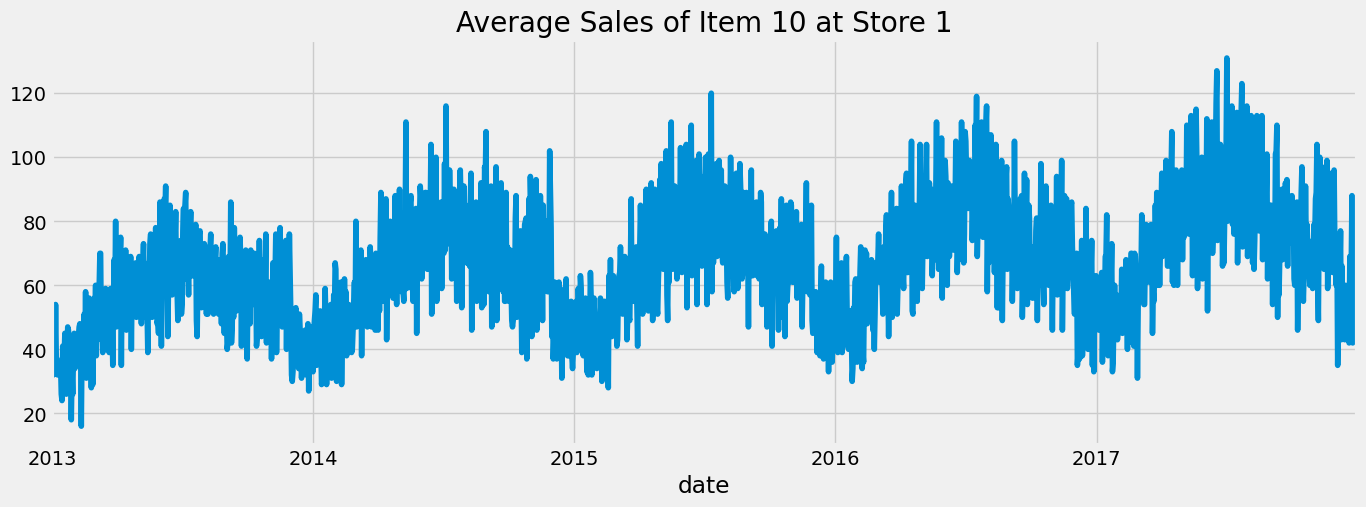

In [456]:
sales[(sales['item']==10) & (sales['store']==1)].groupby('date')['sales'].mean().plot(figsize=(15,5), title='Average Sales of Item 10 at Store 1')

---

## <span style="color:steelblue;">  Machine Learning for Time Series Forecasting  </span>


### <span style="color:DarkGray;">  Data preprocessing and Feature engineering  </span>

#### Extract some useful features (e.g. lag, rolling mean, datetime) to use in a machine learning model and them to the `sales` DataFrame.

In [457]:
# create some lag features
sales['lag_t1'] = sales.groupby(['item', 'store'])['sales'].shift(1)
sales['lag_t7'] = sales.groupby(['item', 'store'])['sales'].shift(7)
sales['lag_t14'] = sales.groupby(['item', 'store'])['sales'].shift(14)
sales['lag_t28'] = sales.groupby(['item', 'store'])['sales'].shift(28)

In [458]:
# rolling mean features
sales['rolling_mean_t7'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(7,closed='left').mean()
sales['rolling_mean_t28'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(28,closed='left').mean()

In [459]:
# rolling max
sales['rolling_max_t7'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(7,closed='left').max()
sales['rolling_max_t28'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(28,closed='left').max()

In [460]:
# Mean absolute deviation
def calculate_mad(series):
    return abs(series - series.mean()).mean()

grouped_mad = sales.groupby(['item', 'store'])['sales'].apply(calculate_mad).reset_index(name='price_mad')

sales = sales.merge(grouped_mad, on=['item', 'store'])


In [461]:
# price delta
sales['price_delta'] = sales.groupby(['item', 'store'])['sales'].shift(1) - sales.groupby(['item', 'store'])['sales'].shift(8)

In [462]:
# sell trend
mean_sales = sales.groupby(['item', 'store'])['sales'].transform('mean')
daily_sales = sales.groupby(['item', 'store', 'date'])['sales'].transform('mean')
sales['sell_trend'] = (daily_sales - mean_sales).astype(np.float16)

In [463]:
# split the datatime
sales['quarter'] = pd.to_datetime(sales['date']).dt.quarter
sales['month'] = pd.to_datetime(sales['date']).dt.month
sales['year'] = pd.to_datetime(sales['date']).dt.year
#sales['week'] = pd.to_datetime(sales['date']).dt.isocalendar().week
#sales['week'].astype('int64')
sales['dayofyear'] = pd.to_datetime(sales['date']).dt.dayofyear
sales['dayofmonth'] = pd.to_datetime(sales['date']).dt.day

In [464]:
sales.dtypes

date                datetime64[ns]
store                        int64
item                         int64
sales                        int64
lag_t1                     float64
lag_t7                     float64
lag_t14                    float64
lag_t28                    float64
rolling_mean_t7            float64
rolling_mean_t28           float64
rolling_max_t7             float64
rolling_max_t28            float64
price_mad                  float64
price_delta                float64
sell_trend                 float16
quarter                      int32
month                        int32
year                         int32
dayofyear                    int32
dayofmonth                   int32
dtype: object

In [465]:
sales.isna().sum()

date                    0
store                   0
item                    0
sales                   0
lag_t1                500
lag_t7               3500
lag_t14              7000
lag_t28             14000
rolling_mean_t7      3501
rolling_mean_t28    14001
rolling_max_t7       3501
rolling_max_t28     14001
price_mad               0
price_delta          4000
sell_trend              0
quarter                 0
month                   0
year                    0
dayofyear               0
dayofmonth              0
dtype: int64

In [466]:
sales.dropna(inplace=True)

In [467]:
sales.dtypes

date                datetime64[ns]
store                        int64
item                         int64
sales                        int64
lag_t1                     float64
lag_t7                     float64
lag_t14                    float64
lag_t28                    float64
rolling_mean_t7            float64
rolling_mean_t28           float64
rolling_max_t7             float64
rolling_max_t28            float64
price_mad                  float64
price_delta                float64
sell_trend                 float16
quarter                      int32
month                        int32
year                         int32
dayofyear                    int32
dayofmonth                   int32
dtype: object

### <span style="color:DarkGray;">  Train and test split  </span>

#### Split sales data into the __train__ and __test__ datasets. 

In [468]:
split_date = "2017-10-01"

In [469]:
train = sales.loc[sales.date < split_date].copy()
test = sales.loc[sales.date >= split_date].copy()

In [470]:
print(train.shape)
print(test.shape)

(852500, 20)
(46000, 20)


In [471]:
train

,date,store,item,sales,lag_t1,lag_t7,lag_t14,lag_t28,rolling_mean_t7,rolling_mean_t28,rolling_max_t7,rolling_max_t28,price_mad,price_delta,sell_trend,quarter,month,year,dayofyear,dayofmonth
29,2013-01-30,1,1,9,6.0,9.0,7.0,11.0,10.428571,10.714286,14.0,18.0,5.389861,-1.0,-10.968750,1,1,2013,30,30
30,2013-01-31,1,1,13,9.0,8.0,16.0,14.0,10.285714,10.464286,14.0,18.0,5.389861,0.0,-6.972656,1,1,2013,31,31
31,2013-02-01,1,1,11,13.0,14.0,7.0,13.0,10.285714,10.392857,14.0,18.0,5.389861,5.0,-8.968750,1,2,2013,32,1
32,2013-02-02,1,1,21,11.0,12.0,18.0,10.0,11.000000,10.357143,14.0,18.0,5.389861,-3.0,1.028320,1,2,2013,33,2
33,2013-02-03,1,1,15,21.0,12.0,15.0,12.0,10.571429,10.285714,13.0,18.0,5.389861,9.0,-4.972656,1,2,2013,34,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912903,2017-09-26,10,50,79,63.0,84.0,70.0,79.0,85.571429,86.928571,99.0,107.0,16.163653,2.0,4.960938,3,9,2017,269,26
912904,2017-09-27,10,50,80,79.0,72.0,84.0,79.0,85.857143,85.678571,99.0,107.0,16.163653,-5.0,5.960938,3,9,2017,270,27
912905,2017-09-28,10,50,82,80.0,89.0,90.0,89.0,85.142857,85.678571,99.0,107.0,16.163653,8.0,7.960938,3,9,2017,271,28
912906,2017-09-29,10,50,90,82.0,97.0,94.0,96.0,86.285714,85.714286,99.0,107.0,16.163653,-7.0,15.960938,3,9,2017,272,29


In [472]:
test

,date,store,item,sales,lag_t1,lag_t7,lag_t14,lag_t28,rolling_mean_t7,rolling_mean_t28,rolling_max_t7,rolling_max_t28,price_mad,price_delta,sell_trend,quarter,month,year,dayofyear,dayofmonth
1734,2017-10-01,1,1,21,30.0,24.0,30.0,23.0,24.428571,23.857143,37.0,37.0,5.389861,-7.0,1.028320,4,10,2017,274,1
1735,2017-10-02,1,1,12,21.0,14.0,22.0,12.0,23.428571,24.000000,30.0,37.0,5.389861,-3.0,-7.972656,4,10,2017,275,2
1736,2017-10-03,1,1,18,12.0,18.0,21.0,26.0,23.000000,23.928571,30.0,37.0,5.389861,-2.0,-1.971680,4,10,2017,276,3
1737,2017-10-04,1,1,15,18.0,27.0,20.0,24.0,22.714286,23.928571,30.0,37.0,5.389861,0.0,-4.972656,4,10,2017,277,4
1738,2017-10-05,1,1,20,15.0,23.0,20.0,29.0,22.714286,23.642857,30.0,37.0,5.389861,-12.0,0.028473,4,10,2017,278,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,41.0,51.0,67.0,76.0,62.857143,65.107143,76.0,86.0,16.163653,-13.0,-11.039062,4,12,2017,361,27
912996,2017-12-28,10,50,59,63.0,63.0,72.0,73.0,61.000000,64.142857,76.0,86.0,16.163653,12.0,-15.039062,4,12,2017,362,28
912997,2017-12-29,10,50,74,59.0,75.0,72.0,66.0,62.714286,63.678571,76.0,86.0,16.163653,-4.0,-0.037231,4,12,2017,363,29
912998,2017-12-30,10,50,62,74.0,70.0,52.0,49.0,62.142857,63.178571,76.0,86.0,16.163653,-1.0,-12.039062,4,12,2017,364,30


#### Create input (`x`) and output (`y`) variables
Note: use __sales__ as the output column.

In [473]:
x_train = train.drop(columns=["sales","date"])
y_train = train["sales"]
x_test = test.drop(columns=["sales","date"])
y_test = test["sales"]

In [474]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(852500, 18) (852500,)
(46000, 18) (46000,)


In [475]:
x_train

,store,item,lag_t1,lag_t7,lag_t14,lag_t28,rolling_mean_t7,rolling_mean_t28,rolling_max_t7,rolling_max_t28,price_mad,price_delta,sell_trend,quarter,month,year,dayofyear,dayofmonth
29,1,1,6.0,9.0,7.0,11.0,10.428571,10.714286,14.0,18.0,5.389861,-1.0,-10.968750,1,1,2013,30,30
30,1,1,9.0,8.0,16.0,14.0,10.285714,10.464286,14.0,18.0,5.389861,0.0,-6.972656,1,1,2013,31,31
31,1,1,13.0,14.0,7.0,13.0,10.285714,10.392857,14.0,18.0,5.389861,5.0,-8.968750,1,2,2013,32,1
32,1,1,11.0,12.0,18.0,10.0,11.000000,10.357143,14.0,18.0,5.389861,-3.0,1.028320,1,2,2013,33,2
33,1,1,21.0,12.0,15.0,12.0,10.571429,10.285714,13.0,18.0,5.389861,9.0,-4.972656,1,2,2013,34,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912903,10,50,63.0,84.0,70.0,79.0,85.571429,86.928571,99.0,107.0,16.163653,2.0,4.960938,3,9,2017,269,26
912904,10,50,79.0,72.0,84.0,79.0,85.857143,85.678571,99.0,107.0,16.163653,-5.0,5.960938,3,9,2017,270,27
912905,10,50,80.0,89.0,90.0,89.0,85.142857,85.678571,99.0,107.0,16.163653,8.0,7.960938,3,9,2017,271,28
912906,10,50,82.0,97.0,94.0,96.0,86.285714,85.714286,99.0,107.0,16.163653,-7.0,15.960938,3,9,2017,272,29


In [476]:
x_test

,store,item,lag_t1,lag_t7,lag_t14,lag_t28,rolling_mean_t7,rolling_mean_t28,rolling_max_t7,rolling_max_t28,price_mad,price_delta,sell_trend,quarter,month,year,dayofyear,dayofmonth
1734,1,1,30.0,24.0,30.0,23.0,24.428571,23.857143,37.0,37.0,5.389861,-7.0,1.028320,4,10,2017,274,1
1735,1,1,21.0,14.0,22.0,12.0,23.428571,24.000000,30.0,37.0,5.389861,-3.0,-7.972656,4,10,2017,275,2
1736,1,1,12.0,18.0,21.0,26.0,23.000000,23.928571,30.0,37.0,5.389861,-2.0,-1.971680,4,10,2017,276,3
1737,1,1,18.0,27.0,20.0,24.0,22.714286,23.928571,30.0,37.0,5.389861,0.0,-4.972656,4,10,2017,277,4
1738,1,1,15.0,23.0,20.0,29.0,22.714286,23.642857,30.0,37.0,5.389861,-12.0,0.028473,4,10,2017,278,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,10,50,41.0,51.0,67.0,76.0,62.857143,65.107143,76.0,86.0,16.163653,-13.0,-11.039062,4,12,2017,361,27
912996,10,50,63.0,63.0,72.0,73.0,61.000000,64.142857,76.0,86.0,16.163653,12.0,-15.039062,4,12,2017,362,28
912997,10,50,59.0,75.0,72.0,66.0,62.714286,63.678571,76.0,86.0,16.163653,-4.0,-0.037231,4,12,2017,363,29
912998,10,50,74.0,70.0,52.0,49.0,62.142857,63.178571,76.0,86.0,16.163653,-1.0,-12.039062,4,12,2017,364,30


### Normalizations

In [477]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#### Standardization

In [478]:
s = 'minmax'

In [479]:
if s == 'minmax':
    scaler = MinMaxScaler()
    scaler_mm = MinMaxScaler() 
    scaler_mm.fit(x_train)

    x_train_n = scaler_mm.transform(x_train)
    x_train_n = pd.DataFrame(x_train_n,columns=x_train.columns)

    x_test_n = scaler_mm.transform(x_test)
    x_test_n = pd.DataFrame(x_test_n,columns=x_test.columns)

elif s == 'standard':

    scaler_std = StandardScaler() 
    scaler_std.fit(x_train)

    x_train_n = scaler_std.transform(x_train)
    x_train_n = pd.DataFrame(x_train_n,columns=x_train.columns)

    x_test_n = scaler_std.transform(x_test)
    x_test_n = pd.DataFrame(x_test_n,columns=x_test.columns)
else:
    pass

### <span style="color:DarkGray;"> Model training and validation </span>

#### Train a  model on the train and validate your model on the test dataset (report your SMAPE score)

In [480]:
def smape(A, F):
    '''
    A : Real Values
    F : Forecast Values
    
    '''
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

#### Linear Regression model

In [481]:
%%time
from sklearn.linear_model import LinearRegression

# Fitting the model on train
model = LinearRegression()
model.fit(x_train, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test)

# Evaluating with SMAPE
print(f"LR SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

LR SMAPE: 1.2063606885687215
CPU times: user 462 ms, sys: 58.2 ms, total: 520 ms
Wall time: 261 ms


#### Linear Regression model - Scaled data

In [482]:
%%time
if 1:
    from sklearn.linear_model import LinearRegression

    # Fitting the model on train
    model = LinearRegression()
    model.fit(x_train_n, y_train)

    # Predicting the outputs for test
    y_pred = model.predict(x_test_n)

    # Evaluating with SMAPE
    print(f"LR SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

LR SMAPE: 1.2063606885684965
CPU times: user 1.39 s, sys: 889 ms, total: 2.28 s
Wall time: 351 ms


#### Your model

In [483]:
%%time
# catboost

from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(x_train, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test)

# Evaluating with SMAPE
print(f"CatBoost SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

Learning rate set to 0.118913
0:	learn: 25.8296359	total: 78.1ms	remaining: 1m 18s
1:	learn: 23.1703018	total: 97.4ms	remaining: 48.6s
2:	learn: 20.8594296	total: 115ms	remaining: 38.3s
3:	learn: 18.7637946	total: 135ms	remaining: 33.6s
4:	learn: 16.9457283	total: 164ms	remaining: 32.6s
5:	learn: 15.3058408	total: 182ms	remaining: 30.1s
6:	learn: 13.8891840	total: 206ms	remaining: 29.3s
7:	learn: 12.6537365	total: 232ms	remaining: 28.8s
8:	learn: 11.5000776	total: 253ms	remaining: 27.8s
9:	learn: 10.5191137	total: 269ms	remaining: 26.7s
10:	learn: 9.6409932	total: 286ms	remaining: 25.7s
11:	learn: 8.8502180	total: 303ms	remaining: 25s
12:	learn: 8.1844214	total: 320ms	remaining: 24.3s
13:	learn: 7.5567333	total: 336ms	remaining: 23.7s
14:	learn: 6.9784909	total: 352ms	remaining: 23.1s
15:	learn: 6.4750567	total: 368ms	remaining: 22.6s
16:	learn: 6.0253162	total: 384ms	remaining: 22.2s
17:	learn: 5.6263026	total: 400ms	remaining: 21.8s
18:	learn: 5.2836005	total: 419ms	remaining: 21.6s


In [484]:
%%time
# catboost - scaled

from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(x_train_n, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test_n)

# Evaluating with SMAPE
print(f"CatBoost SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

Learning rate set to 0.118913
0:	learn: 25.8296359	total: 21.4ms	remaining: 21.4s
1:	learn: 23.1703018	total: 39.1ms	remaining: 19.5s
2:	learn: 20.8594296	total: 55.8ms	remaining: 18.5s
3:	learn: 18.7637946	total: 72.2ms	remaining: 18s
4:	learn: 16.9457283	total: 88.6ms	remaining: 17.6s
5:	learn: 15.3058408	total: 105ms	remaining: 17.4s
6:	learn: 13.8891840	total: 122ms	remaining: 17.2s
7:	learn: 12.6537365	total: 140ms	remaining: 17.3s
8:	learn: 11.5000776	total: 158ms	remaining: 17.4s
9:	learn: 10.5191137	total: 176ms	remaining: 17.4s
10:	learn: 9.6409932	total: 195ms	remaining: 17.6s
11:	learn: 8.8502180	total: 213ms	remaining: 17.6s
12:	learn: 8.1844214	total: 232ms	remaining: 17.6s
13:	learn: 7.5567333	total: 248ms	remaining: 17.5s
14:	learn: 6.9784909	total: 270ms	remaining: 17.8s
15:	learn: 6.4750567	total: 289ms	remaining: 17.7s
16:	learn: 6.0253162	total: 306ms	remaining: 17.7s
17:	learn: 5.6263026	total: 322ms	remaining: 17.6s
18:	learn: 5.2836005	total: 339ms	remaining: 17.5

In [485]:
%%time
# XGBoost

import xgboost as xgb

# Fitting the model on train
model = xgb.XGBRegressor()
model.fit(x_train, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test)

# Evaluating with SMAPE
print(f"XGB SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

XGB SMAPE: 1.9837839250999598
CPU times: user 1min 5s, sys: 863 ms, total: 1min 6s
Wall time: 8.17 s


In [486]:
%%time
# XGBoost -> check if we have overfitting problem or not

import xgboost as xgb

# Fitting the model on train
model = xgb.XGBRegressor()
model.fit(x_train, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_train)

# Evaluating with SMAPE
print(f"XGB SMAPE: {smape(np.c_[y_train],np.c_[y_pred])}")

## results is higher than test so maybe it's fine?

XGB SMAPE: 1.9063626907391749
CPU times: user 1min 6s, sys: 800 ms, total: 1min 7s
Wall time: 8.16 s


In [487]:
%%time
# XGBoost - scaled

import xgboost as xgb

# Fitting the model on train
model = xgb.XGBRegressor()
model.fit(x_train_n, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test_n)

# Evaluating with SMAPE
print(f"XGB SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")



XGB SMAPE: 1.9837833684914838
CPU times: user 1min 5s, sys: 786 ms, total: 1min 5s
Wall time: 7.97 s


In [488]:
%%time

# random forest
from sklearn.ensemble import RandomForestRegressor

# Fitting the model on train
model = RandomForestRegressor()
model.fit(x_train, y_train)

# Predicting the outputs for test

y_pred = model.predict(x_train)

# Evaluating with SMAPE

print(f"RF SMAPE: {smape(np.c_[y_train],np.c_[y_pred])}")


#### Plot store_id = 1, item_id == 10 actual sales data and their prediction from October 2017 to December 2017 (92 days).

In [ ]:
# YOUR CODE

---